<a href="https://colab.research.google.com/github/kangjw1208/Ethereum_Prediction/blob/main/LSTM_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [2]:
df_d = pd.read_csv('https://raw.githubusercontent.com/kangjw1208/Ethereum_Prediction/main/data/Binance_ETHUSDT_d.csv')
df_h = pd.read_csv('https://raw.githubusercontent.com/kangjw1208/Ethereum_Prediction/main/data/Binance_ETHUSDT_1h.csv')

In [3]:
#Function to transform daily ethereum data into a time series data frame with date time index
def to_datetime_day(df):
    
    df.reset_index(inplace=True)
    df.columns = df.iloc[0]
    df.drop(index = df.index[0:2], axis=0, inplace=True)
    
    df['date'] = df['date'].str[0:10]
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
    df.set_index('date', inplace = True)
    
    df.drop(df.columns[[0,1,-1,-2]], axis=1, inplace=True)
    
    for x in df.columns:
        df[x] = df[x].astype(float)
    
    return df

In [4]:
#Function to transform hourly ethereum data into a time series data frame with date time index
def to_datetime_hour(df):
    
    df.reset_index(inplace=True)
    df.columns = df.iloc[0]
    df.drop(index = df.index[0:2], axis=0, inplace=True)
    
    def datetime_func(x):
        if 'AM' in x:
            return pd.to_datetime(x[0:13]+':00:00 AM').strftime('%Y-%m-%d %H:%M:%S')
        elif 'PM' in x:
            return pd.to_datetime(x[0:13]+':00:00 PM').strftime('%Y-%m-%d %H:%M:%S')
        else:
            return pd.to_datetime(x, format='%Y-%m-%d %H:%M:%S')
    
    df['date'] = df['date'].apply(datetime_func)
    df.set_index('date', inplace = True)
    df.drop(df.columns[[0,1,-1,-2]], axis=1, inplace=True)
    
    for x in df.columns:
        df[x] = df[x].astype(float)
    
    return df

In [5]:
to_datetime_day(df_d)

,open,high,low,close,Volume ETH
date,,,,,
2022-01-10,3151.97,3185.00,2928.83,3082.68,529818.3866
2022-01-09,3080.98,3211.72,3057.35,3151.97,275874.1643
2022-01-08,3198.68,3250.00,3000.00,3080.95,400692.1061
2022-01-07,3406.81,3416.76,3064.42,3199.24,669631.7262
2022-01-06,3539.82,3550.43,3300.00,3406.81,496745.7413
...,...,...,...,...,...
2017-08-21,299.10,346.52,294.60,323.29,5134.5400
2017-08-20,290.91,300.53,282.85,299.10,2469.4900
2017-08-19,293.96,299.90,278.00,290.91,2140.0800


In [6]:
to_datetime_hour(df_h)

,open,high,low,close,Volume ETH
date,,,,,
2022-01-10 23:00:00,3062.73,3088.01,3054.06,3082.68,9189.4677
2022-01-10 22:00:00,3074.65,3084.96,3056.33,3062.73,6294.9157
2022-01-10 21:00:00,3082.68,3096.15,3068.12,3074.65,13234.7443
2022-01-10 20:00:00,3029.75,3088.00,3019.17,3082.68,15604.1474
2022-01-10 19:00:00,3042.90,3056.28,3020.21,3029.75,10499.1698
...,...,...,...,...,...
2017-08-17 08:00:00,307.96,309.97,307.00,308.62,150.7500
2017-08-17 07:00:00,302.68,307.96,302.60,307.96,753.1900
2017-08-17 06:00:00,303.10,304.44,301.90,302.68,302.5100


In [7]:
#Creating daily and weekly resampled target variable
target_day = df_d['close'].resample('D').mean()
target_week = df_d['close'].resample('W').mean()

In [8]:
#Function that converts the data into a matrix form that is compatible to LSTM model
def convert_matrix(data, step_size):
    X=list()
    Y=list()
    for i in range(len(data)-step_size):
    d=i+step_size  
    X.append(data[i:d,])
    Y.append(data[d,])
    return np.array(X), np.array(Y)

In [9]:
#Function that scales the data into MinMaxScaler with range of 0 to 1
def minmaxscaler(data):
    target= data.values 
    target = np.reshape(target, (-1, 1)) 
    scaler = MinMaxScaler(feature_range=(0, 1))
    target = scaler.fit_transform(target)
    return target

In [10]:
#Function to split the data into training and test data
def train_test_split(data, ratio):
    train_size = int(len(data) * ratio)
    train, test = data[0:train_size], data[train_size:]
    return train, test

In [11]:
#Function that runs lstm model by taking in the data and returning rmse and test prediction
def lstm_model(data, step_size):

    target = data.values 
    target = np.reshape(target, (-1, 1))
    scaler = MinMaxScaler(feature_range=(0, 1))
    target = scaler.fit_transform(target)

    train, test = train_test_split(target, 0.8)

    X_train, y_train = convert_matrix(train, step_size)
    X_test, y_test = convert_matrix(test, step_size)

    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

    model = Sequential()
    model.add(LSTM(units = 200, activation='relu', return_sequences=True,  input_shape=(X_train.shape[1], step_size)))
    model.add(Dropout(0.2)) 
    model.add(LSTM(units = 150, activation = 'relu'))
    model.add(Dense(units =1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    model.fit(X_train, y_train, epochs=100, batch_size=100, validation_data=(X_test, y_test), verbose=1)

    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)

    train_predict = scaler.inverse_transform(train_predict)
    test_predict = scaler.inverse_transform(test_predict)
    y_train = scaler.inverse_transform(y_train)
    y_test = scaler.inverse_transform(y_test)

    rmse_train = np.sqrt(mean_squared_error(y_train, train_predict))
    rmse_test = np.sqrt(mean_squared_error(y_test, test_predict))


    return rmse_train, rmse_test, test_predict

In [12]:
rmse_train, rmse_test, test_predict_daily = lstm_model(target_day, 100)

Epoch 1/100
12/12 [==============================] - 4s 62ms/step - loss: 0.0050 - val_loss: 0.0190
Epoch 2/100
12/12 [==============================] - 0s 20ms/step - loss: 0.0023 - val_loss: 0.0222
Epoch 3/100
12/12 [==============================] - 0s 21ms/step - loss: 0.0013 - val_loss: 0.3297
Epoch 4/100
12/12 [==============================] - 0s 21ms/step - loss: 7.5107e-04 - val_loss: 0.4998
Epoch 5/100
12/12 [==============================] - 0s 21ms/step - loss: 5.3135e-04 - val_loss: 0.6551
Epoch 6/100
12/12 [==============================] - 0s 21ms/step - loss: 4.2049e-04 - val_loss: 0.3058
Epoch 7/100
12/12 [==============================] - 0s 22ms/step - loss: 3.7302e-04 - val_loss: 0.1112
Epoch 8/100
12/12 [==============================] - 0s 22ms/step - loss: 3.3028e-04 - val_loss: 0.1234
Epoch 9/100
12/12 [==============================] - 0s 20ms/step - loss: 2.7904e-04 - val_loss: 0.0852
Epoch 10/100
12/12 [==============================] - 0s 21ms/step - loss: 2

In [13]:
train, test = train_test_split(target_day, 0.8)

x = len(test_predict_daily)
predict_index = test.index[-x:]
df_prediction = pd.DataFrame(test_predict_daily, index = predict_index, columns = ['prediction'])

RMSE: 491.47


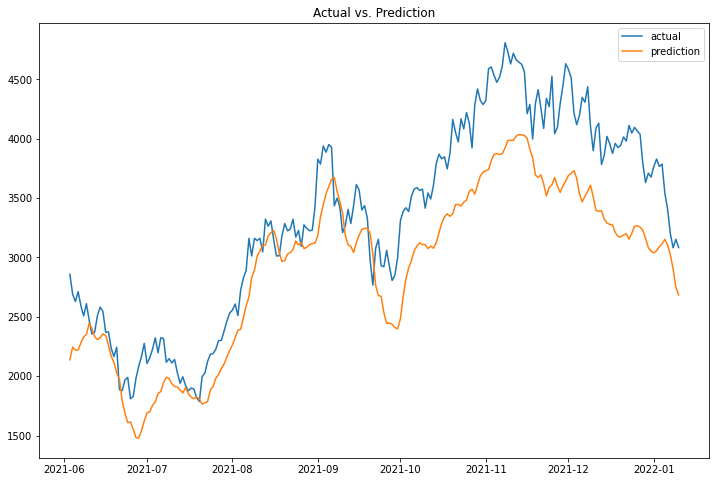

In [14]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(test[-len(df_prediction):], label='actual')
ax.plot(df_prediction['prediction'], label='prediction')
ax.set_title('Actual vs. Prediction');
plt.legend();
print("RMSE:",round(rmse_test,2))

In [15]:
target_hour = df_h['close'].resample('H').mean()
t = target_hour[-2000:]

In [16]:
rmse_train, rmse_test, test_predict_hourly = lstm_model(t, 100)

Epoch 1/100
15/15 [==============================] - 2s 42ms/step - loss: 0.1923 - val_loss: 0.0087
Epoch 2/100
15/15 [==============================] - 0s 17ms/step - loss: 0.0270 - val_loss: 0.0090
Epoch 3/100
15/15 [==============================] - 0s 18ms/step - loss: 0.0157 - val_loss: 0.0084
Epoch 4/100
15/15 [==============================] - 0s 17ms/step - loss: 0.0119 - val_loss: 0.0087
Epoch 5/100
15/15 [==============================] - 0s 18ms/step - loss: 0.0110 - val_loss: 0.0103
Epoch 6/100
15/15 [==============================] - 0s 19ms/step - loss: 0.0094 - val_loss: 0.0111
Epoch 7/100
15/15 [==============================] - 0s 17ms/step - loss: 0.0083 - val_loss: 0.0117
Epoch 8/100
15/15 [==============================] - 0s 19ms/step - loss: 0.0074 - val_loss: 0.0120
Epoch 9/100
15/15 [==============================] - 0s 17ms/step - loss: 0.0070 - val_loss: 0.0127
Epoch 10/100
15/15 [==============================] - 0s 18ms/step - loss: 0.0064 - val_loss: 0.0135

In [17]:
trainn, testt = train_test_split(t, 0.8)

x = len(test_predict_hourly)
predict_index = testt.index[-x:]
df_prediction = pd.DataFrame(test_predict_hourly, index = predict_index, columns = ['prediction'])

RMSE: 182.11


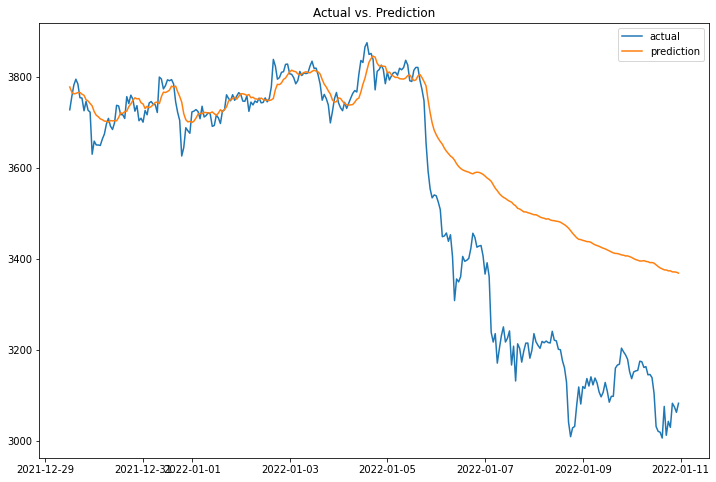

In [18]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(testt[-len(df_prediction):], label='actual')
ax.plot(df_prediction['prediction'], label='prediction')
ax.set_title('Actual vs. Prediction');
plt.legend();
print("RMSE:",round(rmse_test,2))

In [42]:
df_hour = pd.read_csv('https://raw.githubusercontent.com/kangjw1208/Ethereum_Prediction/main/data/Binance_ETHUSDT_1h_updated.csv')

In [43]:
to_datetime_hour(df_hour)

,open,high,low,close,Volume ETH
date,,,,,
2022-01-25 23:00:00,2437.72,2471.46,2430.01,2458.83,14551.4869
2022-01-25 22:00:00,2412.84,2438.21,2404.51,2437.58,8397.5707
2022-01-25 21:00:00,2438.26,2442.11,2404.70,2412.84,15844.8090
2022-01-25 20:00:00,2466.28,2470.65,2430.18,2438.26,23110.6027
2022-01-25 19:00:00,2496.58,2504.58,2466.05,2466.28,16684.5462
...,...,...,...,...,...
2017-08-17 08:00:00,307.96,309.97,307.00,308.62,150.7500
2017-08-17 07:00:00,302.68,307.96,302.60,307.96,753.1900
2017-08-17 06:00:00,303.10,304.44,301.90,302.68,302.5100


In [44]:
df_hour = df_hour['close'].resample('H').mean()

In [45]:
df_hour

date
2017-08-17 04:00:00     300.79
2017-08-17 05:00:00     303.10
2017-08-17 06:00:00     302.68
2017-08-17 07:00:00     307.96
2017-08-17 08:00:00     308.62
                        ...   
2022-01-25 19:00:00    2466.28
2022-01-25 20:00:00    2438.26
2022-01-25 21:00:00    2412.84
2022-01-25 22:00:00    2437.58
2022-01-25 23:00:00    2458.83
Freq: H, Name: close, Length: 38948, dtype: float64

In [46]:
def forecast_price(data, step_size, hour):

    target = data.values 
    target = np.reshape(target, (-1, 1))
    scaler = MinMaxScaler(feature_range=(0, 1))
    target = scaler.fit_transform(target)

    X_train, y_train = convert_matrix(target, step_size)

    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])

    model = Sequential()
    model.add(LSTM(units = 200, activation='relu', return_sequences=True,  input_shape=(X_train.shape[1], step_size)))
    model.add(Dropout(0.2)) 
    model.add(LSTM(units = 150, activation = 'relu'))
    model.add(Dense(units =1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    model.fit(X_train, y_train, epochs=100, batch_size=100, verbose=1)

    x_predict = target[-step_size:]
    prediction = list()
    for i in range(0, hour):
        x_predict = x_predict.reshape(1, 1, int(x_predict.shape[0]))
        yhat = model.predict(x_predict)
        unscaled = scaler.inverse_transform(yhat)
        unscaled = unscaled.tolist()
        unscaled = unscaled[0][0]
        prediction.append(unscaled)
        x_predict = np.append(x_predict, yhat)
        x_predict = x_predict[1:]
    
    return prediction

In [53]:
data_pred = df_hour[-1600:]

In [54]:
prediction = forecast_price(data_pred, 100, 72)

Epoch 1/100
15/15 [==============================] - 2s 14ms/step - loss: 0.1495
Epoch 2/100
15/15 [==============================] - 0s 14ms/step - loss: 0.0162
Epoch 3/100
15/15 [==============================] - 0s 14ms/step - loss: 0.0095
Epoch 4/100
15/15 [==============================] - 0s 15ms/step - loss: 0.0073
Epoch 5/100
15/15 [==============================] - 0s 14ms/step - loss: 0.0067
Epoch 6/100
15/15 [==============================] - 0s 13ms/step - loss: 0.0062
Epoch 7/100
15/15 [==============================] - 0s 14ms/step - loss: 0.0058
Epoch 8/100
15/15 [==============================] - 0s 14ms/step - loss: 0.0050
Epoch 9/100
15/15 [==============================] - 0s 16ms/step - loss: 0.0043
Epoch 10/100
15/15 [==============================] - 0s 14ms/step - loss: 0.0036
Epoch 11/100
15/15 [==============================] - 0s 13ms/step - loss: 0.0034
Epoch 12/100
15/15 [==============================] - 0s 14ms/step - loss: 0.0031
Epoch 13/100
15/15 [=====

In [55]:
date_index = pd.date_range(start=df_hour.index[-1], periods=73, freq='H')

In [56]:
date_index = date_index[1:]

In [57]:
df_pred = pd.DataFrame(prediction, index = date_index, columns = ['price'])

In [75]:
df_pred[8:14]

,price
2022-01-26 08:00:00,2601.079834
2022-01-26 09:00:00,2615.835449
2022-01-26 10:00:00,2635.706055
2022-01-26 11:00:00,2649.319092
2022-01-26 12:00:00,2664.647705
2022-01-26 13:00:00,2672.955078


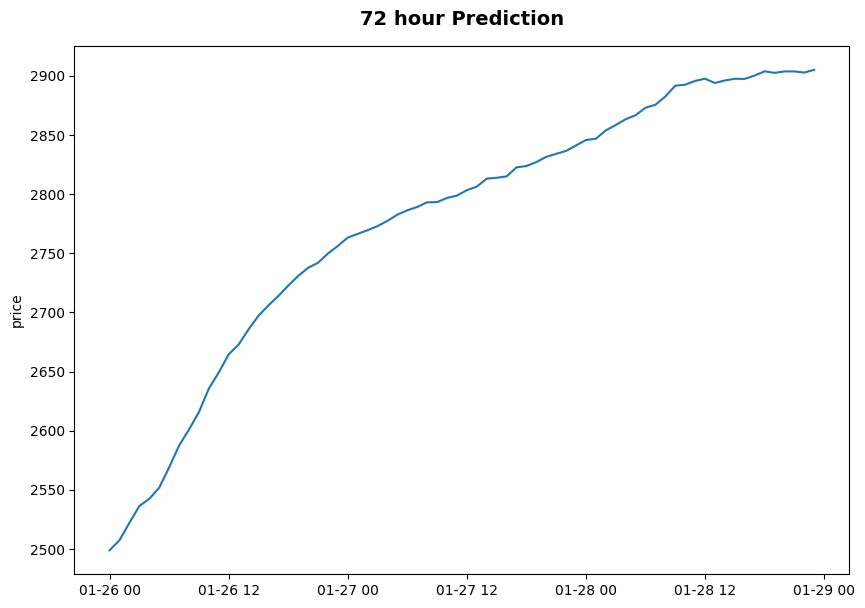

In [74]:
fig, ax = plt.subplots(figsize=(10,7), dpi=100)
x = df_pred.index
y = df_pred.price
ax = sns.lineplot(x=x, y=y)
ax.set_title("72 hour Prediction", fontweight='bold', fontsize=14, pad=15);

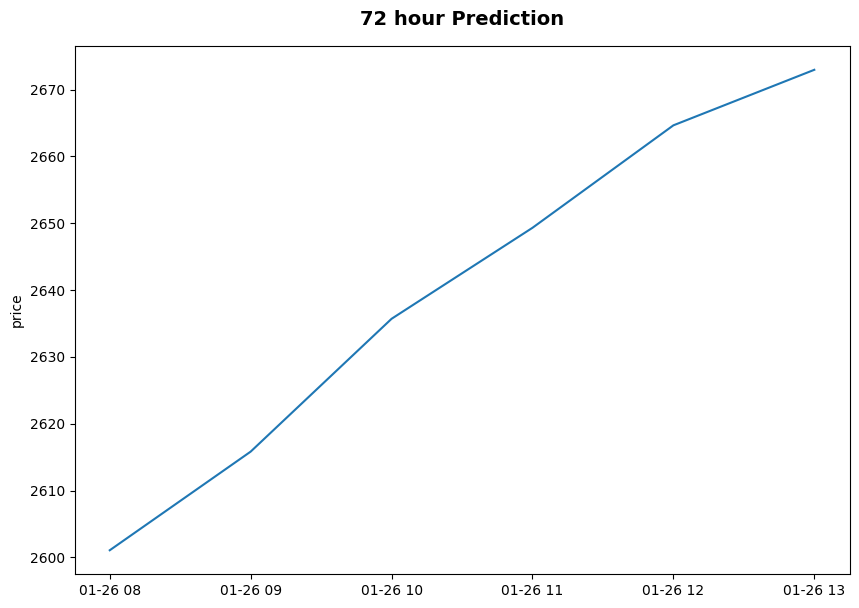

In [76]:
fig, ax = plt.subplots(figsize=(10,7), dpi=100)
x = df_pred.index[8:14]
y = df_pred.price[8:14]
ax = sns.lineplot(x=x, y=y)
ax.set_title("72 hour Prediction", fontweight='bold', fontsize=14, pad=15);